In [291]:
from Levenshtein import distance
import numpy as np
import pandas as pd
import os
import unicodedata
import re

In [221]:
def get_levenshtein(x,y):
    # ordering the inputs by length so that a<=b
    a=max(len(x), len(y))
    b=min(len(x), len(y))
    if a==0: # one of the input is empty
        return 1.
    if a > b+500: # if there are more than 500 more chars then return 100%
        return 1.
    # return the levenshtein distance normalized by the mean length
    mean_length = (a + b)/2.
    return 2 * distance(x,y)/mean_length

def normalize_text(x):
    return unicodedata.normalize("NFKD", x.replace(";"," ")).upper()

In [222]:
def keep_digits(x):
    return ''.join(filter(lambda x: x.isdigit(), x))

In [223]:
projet_loi_AN = normalize_text("EQUILIBRE DANS LE SECTEUR AGRICOLE ET ALIMENTAIRE")
projet_loi_senat = normalize_text("Relations commerciales dans le secteur agricole et alimentaire")

In [312]:
def lecture_amendement(folder, projet_loi, start_offset):
    res=""
    starts=[]
    row=0
    all_amendement = []
    print("Lecture des fichiers dans {} : ".format(folder))
    for f in os.listdir(folder):
        print("{}".format(f), end=',')
        current_file= open(folder+"/"+f, encoding="iso-8859-1")
        
        for line in current_file:
            all_amendement.append(normalize_text(line.strip()))
            if normalize_text(line.strip()[0:len(projet_loi)]) == normalize_text(projet_loi):
                starts.append(row-start_offset)
            row+=1
                
        current_file.close()
    print("")
    print("")
    return starts, all_amendement


def get_amendement_nb(x, nb_offset):
    try:
        return x[nb_offset].replace("N° ","")
    except:
        return "0"


def get_amendement_text(x, start_signal, start_offset):
    start,end=0,0
    for i in range(0, len(x)):
        if x[i]==normalize_text(start_signal):
            start=i+start_offset
            
        if i<len(x)-3 and len(x[i])==0 and len(x[i+1])==0 and len(x[i+2])==0:
            end=i
        
        if len(x[i])<18 and ((normalize_text(x[i][0:5])==normalize_text("EXPOS")) or i==len(x)-1 \
        or (normalize_text(x[i][0:5])==normalize_text("Objet"))):
            end=i
            break
    candidate = x[start:end]
    res=[]
    for i in range(0, len(candidate)):
        if normalize_text("Cet amendement est en cours") in normalize_text(candidate[i]):
            continue
        elif len(candidate[i]) < 2:
            continue
        else:
            res.append(candidate[i])
    return " ".join(res).replace("  ", " ")


def get_amendement_art(x, start_signal):
    has_started=False
    for i in range(0, len(x)):
        if x[i]==normalize_text(start_signal):
            has_started = True
            
        if(has_started) and 'ARTICLE' in normalize_text(x[i]):
            return re.sub(".*ARTICLE ","",x[i])
    return ""
            

def get_amendements(starts, all_amendements, version, nb_line_offset, start_signal, start_offset):
    amendements_nb, amendements_txt, amendements_art, begins, ends = [],[],[],[],[]
    for i in range(0, len(starts)):
        if i<len(starts)-1:
            begin=starts[i]
            end=starts[i+1]
        else:
            begin=starts[-1]
            end=len(all_amendements)
        #print(begin, end)
        current_amendement = all_amendements[begin:end]
        #print(starts[i], starts[i+1])
        amendements_nb.append(get_amendement_nb(current_amendement, nb_line_offset))
        amendements_txt.append(get_amendement_text(current_amendement, start_signal, start_offset))
        amendements_art.append(get_amendement_art(current_amendement, start_signal))
        begins.append(begin)
        ends.append(end)
    
    df_amendement = pd.DataFrame({'nb_'+version:amendements_nb, \
                                  'txt':amendements_txt, \
                                  'article':amendements_art, 'begin':begins, 'end':ends})
    print("Il y a {} amendements dans la liasse {}".format(len(df_amendement), version))
    return df_amendement


In [326]:
starts_1, all_amendement_1 = lecture_amendement("boris_AN/", projet_loi_AN, 5)
starts_2, all_amendement_2 = lecture_amendement("boris_senat/", projet_loi_senat, 0)
df_amendements_1 = get_amendements(starts_1, all_amendement_1,'1', 1, "----------", 3)
df_amendements_2 = get_amendements(starts_2, all_amendement_2,'2', 2, "présenté par", 10)

Lecture des fichiers dans boris_AN/ : 
1-liasse av 1er à al 15 de l'article 1er.txt,2-liasse-Art 1er fin.txt,3-liasse-Apres art 1er à Apres 3.txt,4-liasse art 4 et ap 4.txt,5-liasse-article 5 et après 5 quinquiès.txt,6-liasse-article 6 à après 8.txt,

Lecture des fichiers dans boris_senat/ : 
nouvelle liasse 2 Sénat CAE 1 à 390.txt,

Il y a 824 amendements dans la liasse 1
Il y a 390 amendements dans la liasse 2


In [314]:
starts_1, all_amendement_1 = lecture_amendement("AN/", projet_loi_AN, 5)
starts_2, all_amendement_2 = lecture_amendement("senat/", projet_loi_senat, 2)
df_amendements_1 = get_amendements(starts_1, all_amendement_1,'1', 1, "----------", 3)
df_amendements_2 = get_amendements(starts_2, all_amendement_2,'2', 5, "présenté par", 9)

Lecture des fichiers dans AN/ : 
10_ apräs 15.txt,11_art 15 bis Ö avant 16.txt,12- art 16 Ö la fin.txt,1_  avant 11 et 11 liasse 2.txt,2 _ art 11- apräs 11.txt,3_ 11 bis apräs 11 quindecies.txt,4- art 11 sexdecies -apräs 12.txt,5_ art 12 bis -apräs 13 ter.txt,6_ apräs 13 ter- apräs 14.txt,8_ 14 bis -apräs 14 undecies.txt,9_ art 15.txt,

Lecture des fichiers dans senat/ : 
.DS_Store,liasse sénat 1- 362 COMECO.txt,

Il y a 1379 amendements dans la liasse 1
Il y a 259 amendements dans la liasse 2


In [327]:
mot="CUNICOLE"

df_amendements_1["cont"] = df_amendements_1["txt"].apply(lambda x:mot in x)

df_amendements_2["cont"] = df_amendements_2["txt"].apply(lambda x:mot in x)

df_amendements_1[df_amendements_1.cont==1]
df_amendements_2[df_amendements_2.cont==1]


,nb_2,txt,article,begin,end,cont
36,COM-37,"APRÈS LALINÉA 5, AJOUTER UN ARTICLE III (NO...",13,1396,1438,True


In [329]:
df_amendements_2.tail()

,nb_2,txt,article,begin,end,cont
385,COM-386,ALINÉA 2 1° INSÉRER APRÈS LES MOTS : CÉDÉ...,15,14403,14443,False
386,COM-387,ALINÉA 3 SUPPRIMER LE MOT : CAPITALISTIQUE,15,14443,14481,False
387,COM-388,ALINÉA 5 INSÉRER APRÈS LE MOT : STRATÉGIQU...,15,14481,14520,False
388,COM-389,ALINÉA 2 REMPLACER LES MOTS : AUX ARTICLES L....,15 QUATER (NOUVEAU),14520,14556,False
389,COM-390,ALINÉA 8 REMPLACER LES MOTS : À LENTRÉE EN...,16,14556,18879,False


In [330]:
threshold = 0.01

corresp={}

for i1, row1 in df_amendements_1.iterrows():
    
    if i1 % 20 == 0:
        print( "{} %".format(int(i1 * 100 / len(df_amendements_1))), end="  ")
    for i2,row2 in df_amendements_2.iterrows():
        l = get_levenshtein(row1.txt,row2.txt)
        current_similarity = 1-l
        
        if(current_similarity > threshold):
            
            update = True
            if row2.nb_2 in corresp:
                previous_similarity = corresp[row2.nb_2][3]
                if previous_similarity >= current_similarity:
                    update = False
            
            if update:
                corresp[row2.nb_2] = (row1.nb_1, row1.txt, row2.txt, current_similarity, row2.article)

0 %  2 %  4 %  7 %  

KeyboardInterrupt: 

In [331]:
amendement_id2, amendement_id1, amendement_txt2, amendement_txt1, similarity, article2 \
= [], [], [], [], [], []

for id2 in corresp:
    id1, txt1, txt2, simi, art2 = corresp[id2] 
    amendement_id2.append(str(id2))
    amendement_id1.append(str(id1))
    amendement_txt2.append(txt2)
    article2.append(art2)
    amendement_txt1.append(txt1)
    similarity.append("{0:.0%}".format(simi))
   
df_amendements_matched = pd.DataFrame( { \
                                     "N° v1":amendement_id1, \
                                     "N° v2":amendement_id2, \
                                     "Amendement v1":amendement_txt1, \
                                     "Amendement v2":amendement_txt2, \
                                     "Article v2":article2, \
                                     "Similarité":similarity })
df_amendements_matched.head()

,N° v1,N° v2,Amendement v1,Amendement v2,Article v2,Similarité
0,1992,COM-8,"AVANT LE TITRE 1ER, CRÉER UN TITRE 1A DISPOS...",AVANT LARTICLE 11 INSÉRER UN ARTICLE ADDITIO...,11,42%
1,2181,COM-303,"AVANT LE TITRE IER, IL EST INSÉRÉ UN TITRE A...",INSÉRER UN ARTICLE ADDITIONNEL AINSI RÉDIGÉ...,15,54%
2,2179,COM-44,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,INSÉRER UN ARTICLE ADDITIONNEL AINSI RÉDIGÉ...,1ER,88%
3,2179,COM-84,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,APRÈS LARTICLE 10 OCTIES (NOUVEAU) INSÉRER ...,10 OCTIES (NOUVEAU),69%
4,2179,COM-203,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,INSÉRER UN ARTICLE ADDITIONNEL AINSI RÉDIGÉ...,10 OCTIES (NOUVEAU),87%


In [332]:
df_amendements_matched["id2"] = df_amendements_matched["N° v2"]\
.apply(lambda x:keep_digits(x))\
.astype(int)
df_amendements_matched.sort_values(by="id2", inplace = True, ascending=True)
del df_amendements_matched["id2"]

df_amendements_matched.head()

,N° v1,N° v2,Amendement v1,Amendement v2,Article v2,Similarité
0,1992,COM-8,"AVANT LE TITRE 1ER, CRÉER UN TITRE 1A DISPOS...",AVANT LARTICLE 11 INSÉRER UN ARTICLE ADDITIO...,11,42%
5,2200,COM-9,A LARTICLE L1 DU CODE RURAL ET DE LA PÊCHE M...,AVANT LARTICLE 11 INSÉRER UN ARTICLE ADDITIO...,11,40%
6,2205,COM-16,DANS UN DÉLAI DE SIX MOIS À COMPTER DE LA PU...,APRÈS LARTICLE 10 OCTIES (NOUVEAU) INSÉRER ...,10 OCTIES (NOUVEAU),68%
2,2179,COM-44,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,INSÉRER UN ARTICLE ADDITIONNEL AINSI RÉDIGÉ...,1ER,88%
3,2179,COM-84,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,APRÈS LARTICLE 10 OCTIES (NOUVEAU) INSÉRER ...,10 OCTIES (NOUVEAU),69%


In [333]:
nb_id2_matched = len(df_amendements_matched["N° v2"].unique())
nb_id1_matched = len(df_amendements_matched["N° v1"].unique())
nb_id2 = len(df_amendements_2)
nb_id1 = len(df_amendements_1)
print("""Sur les {} amendements de la nouvelle liasse, {} ont été retrouvés dans la première liasse, \
soit {:.0%}.
Sur les {} amendements de l'ancienne liasse, {} ont été ré-utilisés dans la seconde liasse, \
soit {:.0%}.
      """\
     .format(nb_id2, nb_id2_matched, nb_id2_matched/nb_id2, nb_id1, nb_id1_matched, nb_id1_matched/nb_id1))

Sur les 390 amendements de la nouvelle liasse, 10 ont été retrouvés dans la première liasse, soit 3%.
Sur les 824 amendements de l'ancienne liasse, 8 ont été ré-utilisés dans la seconde liasse, soit 1%.
      


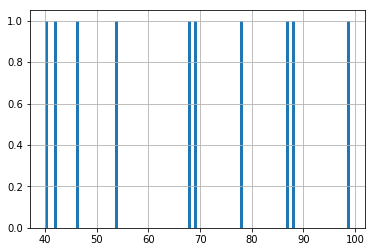

In [334]:
%matplotlib inline
df_amendements_matched["Simi"] = df_amendements_matched["Similarité"]\
.apply(lambda x:int(x.replace("%", "")))
df_amendements_matched.Simi.hist(bins=100)

In [335]:
del df_amendements_matched["Simi"]

In [336]:
df_results = pd.merge(df_amendements_2, df_amendements_matched, left_on = "nb_2", right_on="N° v2")

df_results["N° v2"] = df_results["nb_2"]
df_results["Amendement v2"] = df_results["txt"]

del df_results["begin"], df_results["end"], df_results["nb_2"], df_results["txt"], df_results["cont"]

df_results["N° v1"].fillna("non trouvé", inplace = True)
df_results["Amendement v1"].fillna("non trouvé", inplace = True)
df_results["Similarité"].fillna("0%", inplace = True)

len(df_results)
df_results.head()

,article,N° v1,N° v2,Amendement v1,Amendement v2,Article v2,Similarité
0,11,1992,COM-8,"AVANT LE TITRE 1ER, CRÉER UN TITRE 1A DISPOS...",AVANT LARTICLE 11 INSÉRER UN ARTICLE ADDITIO...,11,42%
1,11,2200,COM-9,A LARTICLE L1 DU CODE RURAL ET DE LA PÊCHE M...,AVANT LARTICLE 11 INSÉRER UN ARTICLE ADDITIO...,11,40%
2,10 OCTIES (NOUVEAU),2205,COM-16,DANS UN DÉLAI DE SIX MOIS À COMPTER DE LA PU...,APRÈS LARTICLE 10 OCTIES (NOUVEAU) INSÉRER ...,10 OCTIES (NOUVEAU),68%
3,1ER,2179,COM-44,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,INSÉRER UN ARTICLE ADDITIONNEL AINSI RÉDIGÉ...,1ER,88%
4,10 OCTIES (NOUVEAU),2179,COM-84,ARTICLE ADDITIONNEL AU TITRE I « LES RÉSIDUS ...,APRÈS LARTICLE 10 OCTIES (NOUVEAU) INSÉRER ...,10 OCTIES (NOUVEAU),69%


In [337]:
df_avis = pd.read_excel("tableau validé SP AN.xls", skiprows=[0])[["N°", "Avis SAJ titre I"]].fillna("")
df_avis["N°"] = df_avis["N°"].astype(str)
pd.read_excel("tableau validé SP AN.xls", skiprows=[0]).columns

Index(['Cpte', 'Ordre', 'Rectifié', 'Article', 'Place', 'N°', 'Auteur',
       'Groupe', 'Mots clefs',
       'Avis MAA (FAV, FAV si sous-amendt, SAG, RET, DEFAV)',
       'Sous-direction ',
       'Avis direction (si différent de l'avis MAA initial)', 'Objet',
       'Argumentaire fiche de banc', 'Objet ', 'ARGUMENTAIRE FICHE DE BANC',
       'Objet .1', 'ARGUMENTAIRE FICHE DE BANC.1', 'Avis SAJ titre I',
       'Direction', 'Valideur 1 cabinet', 'Valideur 2 cabinet',
       'Avis DGCCRF\n', 'MEF DLF', 'MEF - DGDDI', 'MTES',
       'MSS :\n DGS et DGCS\n', 'MEN', 'Justice', 'Avis ministère demandé',
       'Sort'],
      dtype='object')

In [338]:
df_results_final = pd.merge(df_results, df_avis, left_on="N° v1", right_on="N°", how='left')
del df_results_final["N°"], df_results_final["article"]
df_results_final.to_csv("amendements_communs_AN_senat.csv", index=False)
df_results_final.to_excel("amendements_communs_AN_senat.xls", index=False)
df_results_final.head()
print(len(df_results_final))

10


# Matching with previous excel

In [32]:
excel1 = pd.read_excel('ancien_derouleur.xlsx')
excel2 = pd.read_excel('nouveau_derouleur_a_remplir2.xlsx')

In [13]:
def get_avis(df, nb):
    avis = df[df["N°"]==nb]["Avis SAJ "].values[0]
    return avis

def get_corresp_avis(corresp, nb):
    if nb in corresp:
        return get_avis(excel1, corresp[nb][0])
    return ""

def get_old_new_txt(corresp, nb):
    if nb in corresp:
        return (corresp[nb][1], corresp[nb][2], corresp[nb][3])
    return ("","","")

def get_text(df, nb):
    df_t = df[df.nb_2==nb]
    if len(df_t)>0:
        return df_t.txt.values[0]
    return ""

In [14]:
avis, old_txt, new_txt, difference_txt, txt2= [], [], [], [], []
for i2, row2 in excel2.iterrows():
    nb2 = str(row2["N°"])
    avis.append(get_corresp_avis(corresp, nb2))
    extra_cols = get_old_new_txt(corresp, nb2)
    old_txt.append(extra_cols[0])
    new_txt.append(extra_cols[1])
    txt2.append(get_text(df_amendements_2, nb2))
    difference_txt.append(extra_cols[2])

In [33]:
excel2["Avis SAJ"]=avis
excel2["Amendent v1"]=old_txt
excel2["Amendent v2"]=txt2
excel2["Similarité"]=difference_txt

In [37]:
excel2["N°"] = excel2["N°"].apply(lambda x:str(x))
df_tmp = pd.DataFrame(excel2.groupby("txt_amendement")["N°"].agg(['count', "min"])).reset_index()


def has_similar(df_tmp, txt):
    if len(txt)<3:
        return ""
    if df_tmp[df_tmp["txt_amendement"]==txt]["count"].values[0] > 1:
        return 'Amendement similaire au ' + str( df_tmp[df_tmp["txt_amendement"]==txt]["min"].values[0])
    return ""

In [38]:
similars = []
for i2, row2 in excel2.iterrows():
    similars.append(has_similar(df_tmp, row2.txt_amendement))

In [39]:
excel2["Amendent similaire ?"]=similars

In [40]:
excel2.to_excel('nouveau_derouleur_post_traitement.xlsx')